# **Demographic Population Growth**

- Using 2023 as a base, calculate change in population for each demographic group (0-4,5-9 etc), calculating the population change factor from ONS Projections.
- Creating GP List Projections, using the number of patients registered at GP list and population change factor from ONS Projections.
- Comparing and analysing ONS Projections and GP list Projections for each SNEE ICB areas
- Repeating the same for other ONS Scenarios

## Library Imports

In [1]:
import os
from pathlib import Path
if 'notebooks' in str(Path.cwd()):
    os.chdir('..')

from typing import Dict
import yaml
yaml.Dumper.ignore_aliases = lambda *args : True
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from time import sleep

from src.schemas import DataCatalog
from src.various_methods import PlotCounter
import src.constants as constants

# Importing SNEE styles
from sneeifstyles import mpl_style
mpl_style()

## Initial Set-up

In [2]:
# Constants
GP_LIST_SEP_2024 = 'Patients Registered at a GP practice, September 2024' # name of the GP list file
SNEE_SUBICB_CODES = list(constants.ONS_CODES.keys()) # list of sub-icb codes for SNEE
GP_LIST_AGE_BANDS = constants.GP_LIST_AGE_BANDS # age bands for GP list
GP_LIST_LABELS = constants.GP_LIST_AGE_LABELS # labels for GP list
OVER_65_LABELS = GP_LIST_LABELS[-6:]
NOTEBOOK_ALIAS = 'Demographic_pop_growth'

# Loading the Data Catalog
catalog =  DataCatalog.load_from_yaml("data_catalog.yaml")

# Initializing the plotCounter object
plot_counter = PlotCounter(name=NOTEBOOK_ALIAS)

# set up output directories
for i in ['outputs/assumptions', 'outputs/plots', 'outputs/tables']:
    if not os.path.exists(i):
        os.makedirs(i)   

## 1. Loading the Registered Patients at GP Dataset

In [3]:
#Loading the Dataset to get data on number of patients from GP List
gp_patients_reg_catalog_entry = catalog.get_catalog_entry_by_name(GP_LIST_SEP_2024)
gp_patients_df = gp_patients_reg_catalog_entry.load()
gp_patients_df.head()

/workspaces/PrimaryCareDemandAndCapacity/src/schemas.py:146: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_file, **read_csv_kwargs)


,PUBLICATION,EXTRACT_DATE,ORG_TYPE,ORG_CODE,ONS_CODE,POSTCODE,SEX,AGE_GROUP_5,NUMBER_OF_PATIENTS
0,GP_PRAC_PAT_LIST,2024-09-01,Comm Region,Y56,E40000003,NaN,ALL,ALL,11051350
1,GP_PRAC_PAT_LIST,2024-09-01,Comm Region,Y56,E40000003,NaN,FEMALE,0_4,255861
2,GP_PRAC_PAT_LIST,2024-09-01,Comm Region,Y56,E40000003,NaN,FEMALE,10_14,300274
3,GP_PRAC_PAT_LIST,2024-09-01,Comm Region,Y56,E40000003,NaN,FEMALE,15_19,295834
4,GP_PRAC_PAT_LIST,2024-09-01,Comm Region,Y56,E40000003,NaN,FEMALE,20_24,384423


### 1.1. Data Processing

- Renames age bands and columns to match ONS projections
- Removing 'all ages' rows
- Dropping unused columns
- Add column with 5 year age banding
- Filter to only SNEE ICB areas
- Group by sum on 5 year age group

In [4]:
#Replacing AGE_BANDS values to match the ONS_projection data
def rename_gp_list_age_bands_and_columns(df):
    """
    Renames age bands and columns in the given DataFrame to match ONS projections.
    Args:
        df (pandas.DataFrame): The DataFrame containing the data to be processed.
    Returns:
        pandas.DataFrame: A copy of the input DataFrame with the age bands and columns renamed.
    """
    df_ = df.copy()
    # replace these specific cases
    df_['AGE_GROUP_5'] = df_['AGE_GROUP_5'].replace({'90_94':'90+', '95+':'90+'})
    # change _ to - for consistency with ONS projections
    df_['AGE_GROUP_5'] = df_['AGE_GROUP_5'].str.replace('_','-')
    #Renaming the column name to match with ONS projection data
    df_ = df_.rename(columns={'ONS_CODE':'AREA_CODE'})
    return df_
    
    
def filter_gp_list_and_drop_unused_columns(df):
    """
    Filters the given DataFrame by dropping unused columns and rows corresponding to 'ALL' for AGE_GROUP_5. 
    Args:
        df (pandas.DataFrame): The input DataFrame to be filtered. 
    Returns:
        pandas.DataFrame: The filtered DataFrame with dropped columns and rows.
    """
    df_ = df.copy()
    # Dropping unused columns and rows corresponding to 'ALL' for AGE_GROUP_5 
    df_ = df_.loc[df_['AGE_GROUP_5']!='ALL']
    # This is due to the 'ALL' row being a sum of all the other rows, the 'SEX' == ALL rows are also dropped
    df_ = df_.drop(columns=['PUBLICATION','EXTRACT_DATE','ORG_TYPE','POSTCODE','SEX','ORG_CODE'])
    return df_

def filter_snee_icb_areas(df):
    """
    Filters the given DataFrame based on the 'ORG_CODE' column, keeping only the rows
    where the 'ORG_CODE' is in the list of SNEE_SUBICB_CODES.
    Args:
        df (pandas.DataFrame): The DataFrame to be filtered.
    Returns:
        pandas.DataFrame: The filtered DataFrame.
    """
    df_ = df.copy()
    df_ = df_.loc[df_['AREA_CODE'].isin(SNEE_SUBICB_CODES)]
    return df_

def groupbysum_area_and_age_group_and_rename_ons_codes(df):
    """
    Groups the DataFrame by AREA_CODE and AGE_GROUP_5, sums the values, drops the AGE_GROUP column if present,
    and renames the index using ONS_CODES.
    Args:
        df (pandas.DataFrame): The input DataFrame.
    Returns:
        pandas.DataFrame: The modified DataFrame with grouped, summed, and renamed values.
    """
    df_ = df.copy()
    # Grouping by AREA_CODE and AGE_GROUP_5 and summing the values
    df_ = df_.groupby(['AREA_CODE','AGE_GROUP_5'], observed=False).sum()
    df_ = df_.drop(columns=['AGE_GROUP'], errors='ignore')
    # Renaming ONS codes with Actual sub icb names
    df_ = df_.rename(index=constants.ONS_CODES)
    return df_

gp_patients_df = (gp_patients_df
                  .pipe(rename_gp_list_age_bands_and_columns)
                  .pipe(filter_gp_list_and_drop_unused_columns)
                  .pipe(filter_snee_icb_areas)
                  .pipe(groupbysum_area_and_age_group_and_rename_ons_codes))

gp_patients_df.head()

NUMBER_OF_PATIENTS
AREA_CODE              AGE_GROUP_5                    
Ipswich & East Suffolk 0-4                       17916
                       10-14                     24285
                       15-19                     24206
                       20-24                     19972
                       25-29                     22902

## 2. Loading ONS Population projections (Principal Projection)

In [5]:
# Loading the first scenario
ons_projection_catalog_entry = catalog.get_scenario_catalog_entry_by_name('ONS Population projections','Principal projection')
ons_projections_df = ons_projection_catalog_entry.load()
ons_projections_df.head()

,AREA_CODE,AREA_NAME,COMPONENT,SEX,AGE_GROUP,2018,2019,2020,2021,2022,...,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043
0,E38000004,NHS Barking and Dagenham CCG,Population,persons,0,3819.0,3539.476,3553.996,3545.026,3503.164,...,3485.017,3512.290,3542.499,3574.884,3607.783,3638.390,3663.012,3682.648,3697.617,3706.681
1,E38000004,NHS Barking and Dagenham CCG,Population,persons,1,3923.0,3841.214,3570.205,3583.060,3571.184,...,3482.414,3507.074,3534.224,3564.456,3597.080,3630.402,3661.624,3687.005,3707.455,3723.301
2,E38000004,NHS Barking and Dagenham CCG,Population,persons,2,4050.0,3912.292,3826.447,3565.341,3575.791,...,3448.544,3469.903,3494.032,3520.703,3550.533,3582.885,3616.072,3647.352,3672.985,3693.800
3,E38000004,NHS Barking and Dagenham CCG,Population,persons,3,3822.0,4036.658,3906.033,3816.546,3563.662,...,3426.572,3442.075,3462.911,3486.569,3512.830,3542.304,3574.383,3607.421,3638.690,3664.447
4,E38000004,NHS Barking and Dagenham CCG,Population,persons,4,3905.0,3805.264,4003.299,3879.217,3788.087,...,3394.732,3405.045,3420.062,3440.323,3463.422,3489.140,3518.097,3549.706,3582.360,3613.373


### 2.1. Data Processing
- Removing 'all ages' rows
- removing columns prior to 2024
- removing 'AREA NAME' 'COMPONENT' and 'SEX' column
- Add column with 5 year age banding
- Filter to only SNEE ICB areas
- Group by sum on 5 year age group

In [6]:
#Removing values corresponding to 'All ages' in the 'AGE_GROUP' column and dropping unused columns

def rename_ons_columns_and_drop_unused(df) -> pd.DataFrame:
    """
    Rename columns in the DataFrame and drop unused columns.
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    Returns:
    pd.DataFrame: The modified DataFrame with renamed and dropped columns.
    """
    df_ = df.copy()
    df_ = df_.loc[df_['AGE_GROUP'] != 'All ages']
    df_ = df_.drop(columns=['AREA_NAME', 'COMPONENT', 'SEX', '2018', '2019', '2020', '2021', '2022','2023'])
    return df_


def convert_ons_projection_to_5yr_bins(df):
    """
    Convert the ONS projection data to 5-year age bands.
    Args:
        df (pandas.DataFrame): The input DataFrame containing the ONS projection data.
    Returns:
        pandas.DataFrame: The DataFrame with the ONS projection data converted to 5-year age bands.
    """
    df_ = df.copy()

    # replace the text '90 and over' with '90' to match the GP list data
    df_['AGE_GROUP'] = df_['AGE_GROUP'].astype(str).str.replace('90 and over','90')
    #Converting AGE_GROUP data type to int
    df_['AGE_GROUP'] = df_['AGE_GROUP'].astype(int)

    #Adding the column for Age Bands as 'AGE_GROUP_5'
    df_['AGE_GROUP_5'] = pd.cut(df_['AGE_GROUP'], bins=GP_LIST_AGE_BANDS, labels=GP_LIST_LABELS, include_lowest=True, right=False, ordered=True)
    return df_


ons_projections_df = (ons_projections_df
                    .pipe(rename_ons_columns_and_drop_unused)
                    .pipe(convert_ons_projection_to_5yr_bins)
                    .pipe(filter_snee_icb_areas)
                    .pipe(groupbysum_area_and_age_group_and_rename_ons_codes))
ons_projections_df.head()

2024       2025       2026  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19698.373  19604.966  19527.257   
                       5-9          22378.224  21998.493  21529.082   
                       10-14        25016.257  24783.209  24569.717   
                       15-19        23496.655  23897.784  24193.275   
                       20-24        17173.888  17191.096  17520.013   

                                         2027       2028       2029  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19483.805  19446.523  19414.341   
                       5-9          21261.284  21050.186  20983.672   
                       10-14        24249.751  24005.345  23584.788   
                       15-19        24317.998  24191.858  24085.124   
                       20-24        17987.881  18489.898  18808.913   

                                         2030       2031       2032  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19391.237  19381.836  19393.561   
                       5-9          20896.032  20825.220  20787.879   
                       10-14        23208.398  22734.049  22463.455   
                       15-19        23861.980  23735.101  23447.633   
                       20-24        19207.344  19504.800  19722.030   

                                         2033       2034       2035  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19429.657  19490.582  19575.604   
                       5-9          20756.586  20730.435  20713.191   
                       10-14        22247.084  22183.313  22097.687   
                       15-19        23183.517  22773.296  22376.525   
                       20-24        19737.583  19789.355  19742.953   

                                         2036       2037       2038  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          19686.005  19821.500  19978.838   
                       5-9          20709.948  20728.187  20771.506   
                       10-14        22028.982  21994.096  21965.440   
                       15-19        21998.140  21733.338  21566.061   
                       20-24        19656.351  19404.588  19195.243   

                                         2039       2040       2041  \
AREA_CODE              AGE_GROUP_5                                    
Ipswich & East Suffolk 0-4          20152.670  20332.876  20507.740   
                       5-9          20840.531  20934.368  21054.439   
                       10-14        21942.197  21928.291  21928.799   
                       15-19        21499.806  21422.362  21367.768   
                       20-24        18928.754  18660.077  18324.626   

                                         2042       2043  
AREA_CODE              AGE_GROUP_5                        
Ipswich & East Suffolk 0-4          20666.628  20800.504  
                       5-9          21200.433  21369.098  
                       10-14        21951.560  22000.292  
                       15-19        21336.679  21311.481  
                       20-24        18080.678  17917.411

### 2.2. Calculating the population change factor for each year 
- 2024 as baseline

In [7]:
# create a baseline (series/1 column)
pop_baseline:pd.Series = ons_projections_df['2024']
# divide the projections by the baseline to get the relative factors
snee_factors_ons_projections:pd.DataFrame = ons_projections_df.div(pop_baseline, axis=0).round(5)
snee_factors_ons_projections.head(5)

2024     2025     2026     2027     2028  \
AREA_CODE              AGE_GROUP_5                                             
Ipswich & East Suffolk 0-4           1.0  0.99526  0.99131  0.98911  0.98721   
                       5-9           1.0  0.98303  0.96205  0.95009  0.94065   
                       10-14         1.0  0.99068  0.98215  0.96936  0.95959   
                       15-19         1.0  1.01707  1.02965  1.03496  1.02959   
                       20-24         1.0  1.00100  1.02015  1.04740  1.07663   

                                       2029     2030     2031     2032  \
AREA_CODE              AGE_GROUP_5                                       
Ipswich & East Suffolk 0-4          0.98558  0.98441  0.98393  0.98453   
                       5-9          0.93768  0.93377  0.93060  0.92893   
                       10-14        0.94278  0.92773  0.90877  0.89795   
                       15-19        1.02504  1.01555  1.01015  0.99791   
                       20-24        1.09520  1.11840  1.13572  1.14837   

                                       2033     2034     2035     2036  \
AREA_CODE              AGE_GROUP_5                                       
Ipswich & East Suffolk 0-4          0.98636  0.98945  0.99377  0.99937   
                       5-9          0.92754  0.92637  0.92560  0.92545   
                       10-14        0.88931  0.88676  0.88333  0.88059   
                       15-19        0.98667  0.96921  0.95233  0.93622   
                       20-24        1.14928  1.15229  1.14959  1.14455   

                                       2037     2038     2039     2040  \
AREA_CODE              AGE_GROUP_5                                       
Ipswich & East Suffolk 0-4          1.00625  1.01424  1.02306  1.03221   
                       5-9          0.92627  0.92820  0.93129  0.93548   
                       10-14        0.87919  0.87805  0.87712  0.87656   
                       15-19        0.92495  0.91784  0.91502  0.91172   
                       20-24        1.12989  1.11770  1.10218  1.08654   

                                       2041     2042     2043  
AREA_CODE              AGE_GROUP_5                             
Ipswich & East Suffolk 0-4          1.04109  1.04915  1.05595  
                       5-9          0.94084  0.94737  0.95491  
                       10-14        0.87658  0.87749  0.87944  
                       15-19        0.90940  0.90807  0.90700  
                       20-24        1.06701  1.05280  1.04329

## 3. Creating GP Projections dataframe
- **Multiplying each year's projection factor from ONS Projections with the number of patients from GP list**

In [8]:
# create a dict containing the projections for each scenario in the ONS projections
gp_list_projections:Dict[str,pd.DataFrame] = {}
gp_list_2023:pd.Series = gp_patients_df['NUMBER_OF_PATIENTS'].copy()
for scenario_entry in catalog.get_top_level_scenario_by_name('ONS Population projections').scenarios:
    print("Collecting: ", scenario_entry.name)
    scenario_name = scenario_entry.name
    scenario_df = (
        scenario_entry.load()
    .pipe(rename_ons_columns_and_drop_unused)
    .pipe(convert_ons_projection_to_5yr_bins)
    .pipe(filter_snee_icb_areas)
    .pipe(groupbysum_area_and_age_group_and_rename_ons_codes)
    .rename(index=constants.ONS_CODES)
    .div(pop_baseline, axis=0).round(5)
    )
    # multiply the scenario growth factors by the GP list patients
    gp_list_projections[scenario_entry.name] = scenario_df.multiply(gp_list_2023,axis=0).round(0).astype(int)
    sleep(10) #  ons seems to mbe blocking us, so we sleep for 10 second

gp_list_projections['Principal projection'].head()

Collecting:  Principal projection
Collecting:  10 year migration variant
Collecting:  High international migration variant
Collecting:  Low international migration variant
Collecting:  Alternative internal migration variant


2024   2025   2026   2027   2028   2029  \
AREA_CODE              AGE_GROUP_5                                             
Ipswich & East Suffolk 0-4          17916  17831  17760  17721  17687  17658   
                       5-9          21883  21512  21053  20791  20584  20519   
                       10-14        24285  24059  23852  23541  23304  22895   
                       15-19        24206  24619  24924  25052  24922  24812   
                       20-24        19972  19992  20374  20919  21502  21873   

                                     2030   2031   2032   2033   2034   2035  \
AREA_CODE              AGE_GROUP_5                                             
Ipswich & East Suffolk 0-4          17637  17628  17639  17672  17727  17804   
                       5-9          20434  20364  20328  20297  20272  20255   
                       10-14        22530  22069  21807  21597  21535  21452   
                       15-19        24582  24452  24155  23883  23461  23052   
                       20-24        22337  22683  22935  22953  23014  22960   

                                     2036   2037   2038   2039   2040   2041  \
AREA_CODE              AGE_GROUP_5                                             
Ipswich & East Suffolk 0-4          17905  18028  18171  18329  18493  18652   
                       5-9          20252  20270  20312  20379  20471  20588   
                       10-14        21385  21351  21323  21301  21287  21288   
                       15-19        22662  22389  22217  22149  22069  22013   
                       20-24        22859  22566  22323  22013  21700  21310   

                                     2042   2043  
AREA_CODE              AGE_GROUP_5                
Ipswich & East Suffolk 0-4          18797  18918  
                       5-9          20731  20896  
                       10-14        21310  21357  
                       15-19        21981  21955  
                       20-24        21027  20837

## 4. Visualisations
### 4.1. Population growth scenarios

/tmp/ipykernel_62397/779555969.py:35: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


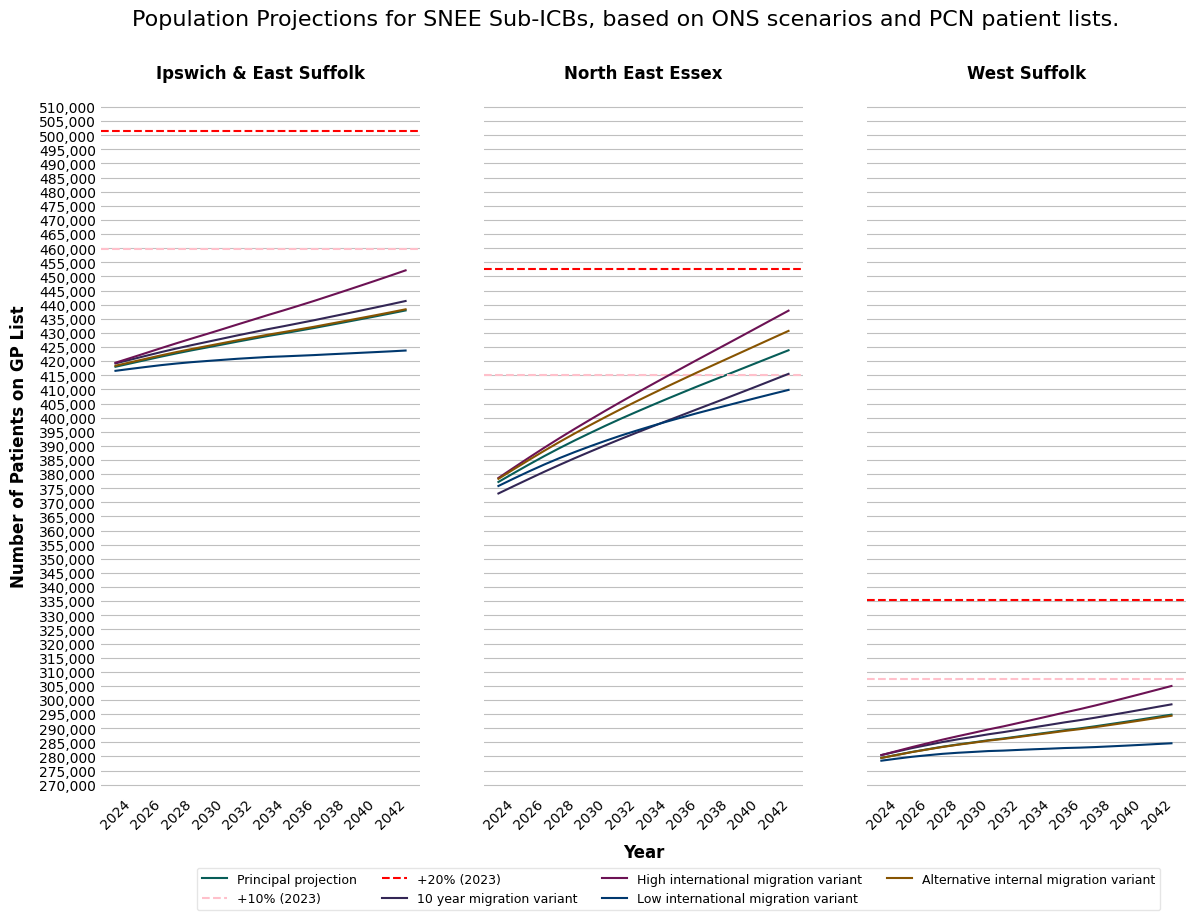

In [9]:
fig, axes = plt.subplots(1,3,figsize=(14,9), sharey=True)
fig.suptitle("Population Projections for SNEE Sub-ICBs, based on ONS scenarios and PCN patient lists.", fontsize=16)
scenario_count = 0
for scenario_name, scenario_df in gp_list_projections.items():
    scenario_total_df_ = scenario_df.copy().reset_index().rename(columns={'AREA_CODE':'Sub-ICB','AGE_GROUP_5':'Age Band'})
    scenario_total_df_ = scenario_total_df_.groupby('Sub-ICB').sum(numeric_only=True).T
    scenario_total_df_.index.name = 'Year'
    
    for i, sub_icb in enumerate(scenario_total_df_.columns):
        axes[i].yaxis.set_major_locator(ticker.MultipleLocator(5000))
        # set y format to show thousands
        axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2))
        # show y ticks
        axes[i].yaxis.set_ticks_position('both')
        axes[i].plot(scenario_total_df_[sub_icb], label=scenario_name)
        # set ticks on y axis to 10000 per tick
        axes[i].set_title(sub_icb)

        if i == 0:
            axes[i].set_ylabel('Number of Patients on GP List')
        if i == 1:
            axes[i].set_xlabel('Year')

        if scenario_name == 'Principal projection':
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.1, color='pink', linestyle='--', label='+10% (2023)')
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.2, color='r', linestyle='--', label='+20% (2023)')

        # rotate the x-axis labels
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(45)
    scenario_count += 1

axes[0].legend(loc=(0.3,-0.17), ncol=4)
plt.tight_layout() 
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300)

### 4.2. Over 65's Scenarios

/tmp/ipykernel_62397/2705924788.py:42: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


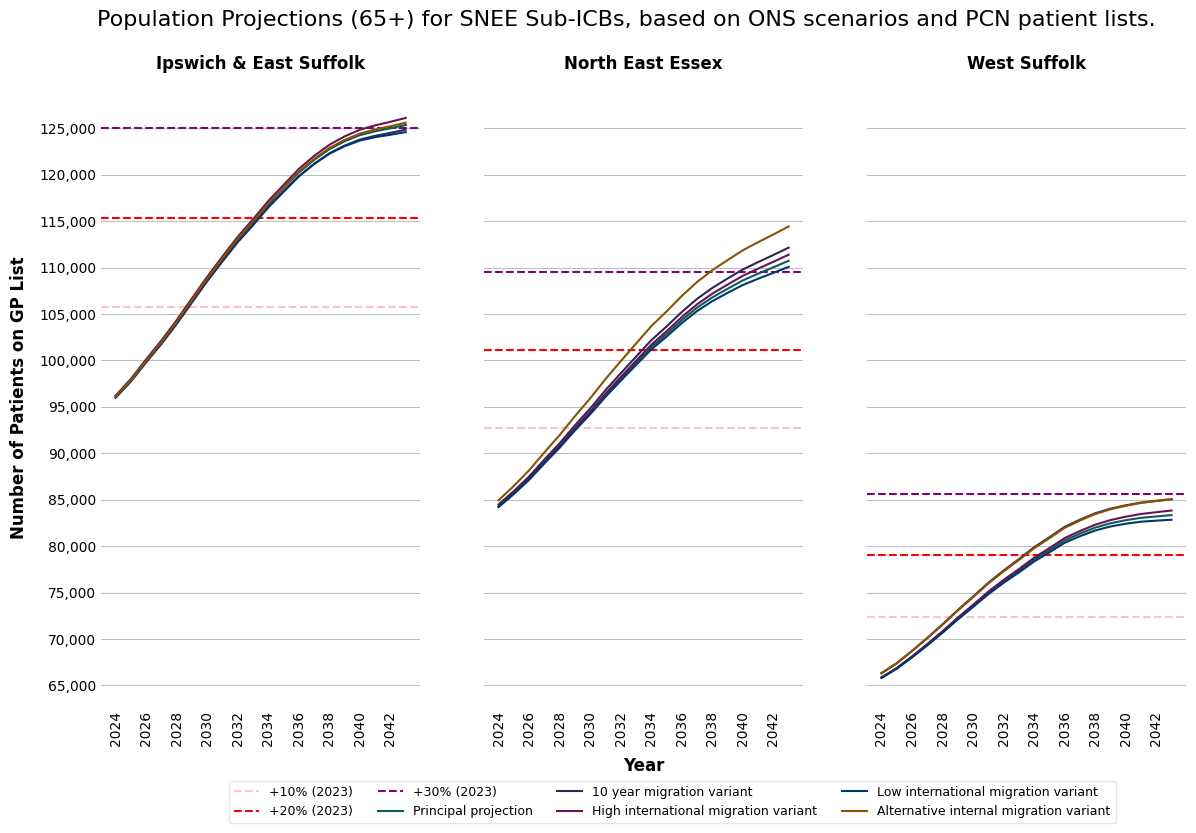

In [10]:
fig, axes = plt.subplots(1,3,figsize=(14,8), sharey=True)
fig.suptitle("Population Projections (65+) for SNEE Sub-ICBs, based on ONS scenarios and PCN patient lists.", fontsize=16)
scenario_count = 0
for scenario_name, scenario_df in gp_list_projections.items():
    scenario_total_df_ = scenario_df.copy().reset_index().rename(columns={'AREA_CODE':'Sub-ICB','AGE_GROUP_5':'Age Band'})
    scenario_total_df_ = scenario_total_df_.loc[scenario_total_df_['Age Band'].isin(OVER_65_LABELS)]    
    scenario_total_df_ = scenario_total_df_.groupby('Sub-ICB').sum(numeric_only=True).T
    scenario_total_df_.index.name = 'Year'

    # if scenario_name == 'Principal projection':
    #     for column in scenario_total_df_.columns:
    #         ten_percents[column] = scenario_total_df_[column].iloc[0] * 1.1
    #         twenty_percents[column] = scenario_total_df_[column].iloc[0] * 1.2
            
    for i, sub_icb in enumerate(scenario_total_df_.columns):
        axes[i].yaxis.set_major_locator(ticker.MultipleLocator(5000))
        # set y format to show thousands
        axes[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
        axes[i].xaxis.set_major_locator(ticker.MultipleLocator(2))

        if scenario_name == 'Principal projection':
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.1, color='pink', linestyle='--', label='+10% (2023)')
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.2, color='r', linestyle='--', label='+20% (2023)')
            axes[i].axhline(y=scenario_total_df_[sub_icb].iloc[0]*1.3, color='purple', linestyle='--', label='+30% (2023)')
        # show y ticks
        axes[i].yaxis.set_ticks_position('both')
        axes[i].plot(scenario_total_df_[sub_icb], label=scenario_name)
        # set ticks on y axis to 10000 per tick
        axes[i].set_title(sub_icb)

        if i == 0:
            axes[i].set_ylabel('Number of Patients on GP List')
        if i == 1:
            axes[i].set_xlabel('Year')

        # rotate the x-axis labels
        for tick in axes[i].get_xticklabels():
            tick.set_rotation(90)
    scenario_count += 1

axes[0].legend(loc=(0.4,-0.19), ncol=4)
plt.tight_layout()
plt.savefig(f"{plot_counter.plot_name}.png", dpi=300, bbox_inches='tight')

## 5. Export the data

In [11]:
template_df = gp_list_projections['Principal projection'].copy().reset_index()

# create a dictionary with year : 0
years_template_dict:Dict[int,int] = {year: 0 for year in template_df.columns[2:]}
groups_template_dict:Dict[str,dict] = {group : years_template_dict.copy() for group in template_df['AGE_GROUP_5'].unique()}
template_dict = {area:groups_template_dict.copy() for area in template_df['AREA_CODE'].unique()}
scenarios_template_dict = {scenario:template_dict.copy() for scenario in gp_list_projections.keys()}

for scenario, scenario_df in gp_list_projections.items():
    for index, row in scenario_df.copy().reset_index().iterrows():
        row_dict = row.to_dict()
        area = row_dict.pop('AREA_CODE')
        ages = row_dict.pop('AGE_GROUP_5')
        scenarios_template_dict[scenario][area][ages] = {int(k):v for k,v in row_dict.items()}

In [12]:
with open(constants.POPULATION_PROJECTIONS_OUTPUT_FILENAME, 'w') as file:
    documents = yaml.dump(scenarios_template_dict, file, default_flow_style=False)